# Ejercicio proyecto: Desarrollo de Soluciones en IA training - Reto proyecto 2. Aplica técnicas de aumento de imágenes 
## Autor: Sergio Fernández Munguía
### 1. Aumento de imágenes

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.transforms as transforms
from torchvision.transforms import functional as F
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import torch.nn as nn
import torch.optim as optim

In [2]:
# Cargar datos CSV
ruta = 'sign_mnist_train/sign_mnist_train.csv'
data = pd.read_csv(ruta)
y = data['label'].values
data = data.drop(columns='label').to_numpy()
X = data.reshape(-1, 28, 28).astype(np.float32) / 255.0

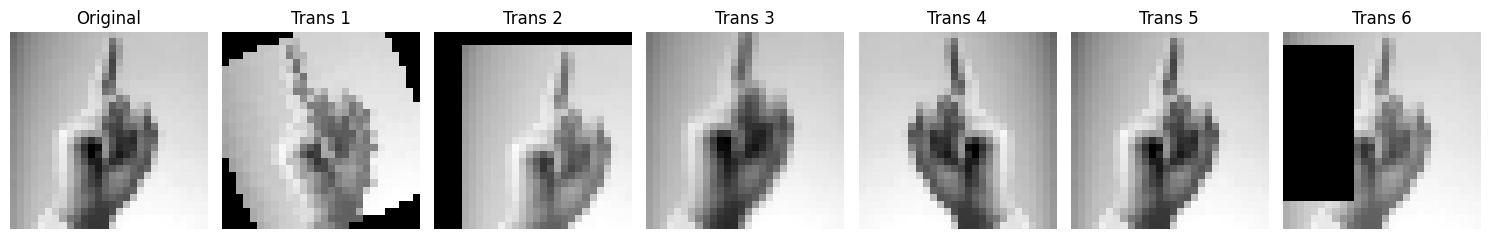

In [3]:
# Seleccionar una imagen
img = X[0]
img_tensor = torch.tensor(img).unsqueeze(0).unsqueeze(0)  # (1, 1, 28, 28)

# Definir transformaciones
transformaciones = [
    transforms.RandomRotation(30),
    transforms.RandomAffine(degrees=0, translate=(0.2, 0.2)),
    transforms.RandomResizedCrop(28, scale=(0.8, 1.0)),
    transforms.RandomHorizontalFlip(p=1.0),
    transforms.ColorJitter(brightness=0.5),
    transforms.RandomErasing(p=1.0, scale=(0.02, 0.33), ratio=(0.3, 3.3))
]

# Aplicar transformaciones y visualizar
fig, axes = plt.subplots(1, 7, figsize=(15, 4))
axes[0].imshow(img, cmap='gray')
axes[0].set_title('Original')
axes[0].axis('off')

for i, transform in enumerate(transformaciones):
    augmented_img = transform(img_tensor.clone()).squeeze().numpy()
    axes[i + 1].imshow(augmented_img, cmap='gray')
    axes[i + 1].set_title(f'Trans {i+1}')
    axes[i + 1].axis('off')

plt.tight_layout()
plt.show()

### 2. CNN para clasificación

In [4]:
# Preparar tensores
X_tensor = torch.tensor(X).unsqueeze(1)
y_tensor = torch.tensor(y)

# División en train y val
X_train, X_val, y_train, y_val = train_test_split(X_tensor, y_tensor, test_size=0.2, random_state=42)

train_ds = TensorDataset(X_train, y_train)
val_ds = TensorDataset(X_val, y_val)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_ds, batch_size=32, num_workers=2)


In [5]:
# Definir CNN
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1)
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1)
        self.fc1 = nn.Linear(32 * 7 * 7, 128)
        self.fc2 = nn.Linear(128, 25)  # 25 clases (sin J ni Z)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.pool(self.relu(self.conv1(x)))  # -> (16, 14, 14)
        x = self.pool(self.relu(self.conv2(x)))  # -> (32, 7, 7)
        x = x.view(-1, 32 * 7 * 7)
        x = self.relu(self.fc1(x))
        return self.fc2(x)

model = CNN()
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

In [6]:
# Entrenar el modelo
for epoch in range(5):
    model.train()
    running_loss = 0.0
    for xb, yb in train_loader:
        preds = model(xb)
        loss = criterion(preds, yb)
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    print(f"Época {epoch+1}, Pérdida entrenamiento: {running_loss/len(train_loader):.4f}")

    # Validación
    model.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            preds = model(xb)
            pred_labels = preds.argmax(dim=1)
            correct += (pred_labels == yb).sum().item()
            total += yb.size(0)
    acc = correct / total
    print(f"Precisión validación: {acc:.4f}")

Época 1, Pérdida entrenamiento: 1.2727
Precisión validación: 0.8620
Época 2, Pérdida entrenamiento: 0.2363
Precisión validación: 0.9743
Época 3, Pérdida entrenamiento: 0.0533
Precisión validación: 0.9989
Época 4, Pérdida entrenamiento: 0.0142
Precisión validación: 0.9993
Época 5, Pérdida entrenamiento: 0.0321
Precisión validación: 1.0000
